<a href="https://colab.research.google.com/github/KiykoHanna/Stepik-DeepLearning/blob/main/%5Bhw%5Dgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tommykamaz/faces-dataset-small

Mounted at /content/gdrive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 3.97G/3.99G [00:37<00:00, 172MB/s]
100% 3.99G/3.99G [00:37<00:00, 113MB/s]


In [4]:
!unzip /content/faces-dataset-small.zip
   


Archive:  /content/faces-dataset-small.zip
  inflating: faces_dataset_small/00055.png  
  inflating: faces_dataset_small/00237.png  
  inflating: faces_dataset_small/00240.png  
  inflating: faces_dataset_small/00241.png  
  inflating: faces_dataset_small/00242.png  
  inflating: faces_dataset_small/00243.png  
  inflating: faces_dataset_small/00244.png  
  inflating: faces_dataset_small/00245.png  
  inflating: faces_dataset_small/00246.png  
  inflating: faces_dataset_small/00247.png  
  inflating: faces_dataset_small/00248.png  
  inflating: faces_dataset_small/00249.png  
  inflating: faces_dataset_small/00253.png  
  inflating: faces_dataset_small/00255.png  
  inflating: faces_dataset_small/00257.png  
  inflating: faces_dataset_small/00258.png  
  inflating: faces_dataset_small/00259.png  
  inflating: faces_dataset_small/00260.png  
  inflating: faces_dataset_small/00261.png  
  inflating: faces_dataset_small/00262.png  
  inflating: faces_dataset_small/00263.png  
  inflating:

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [5]:
DATA_DIR = '/content/sample_data/f_d_s'
image_size = 64
batch_size = 64

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [7]:
train_dl = get_dataloader(image_size, batch_size)

In [8]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


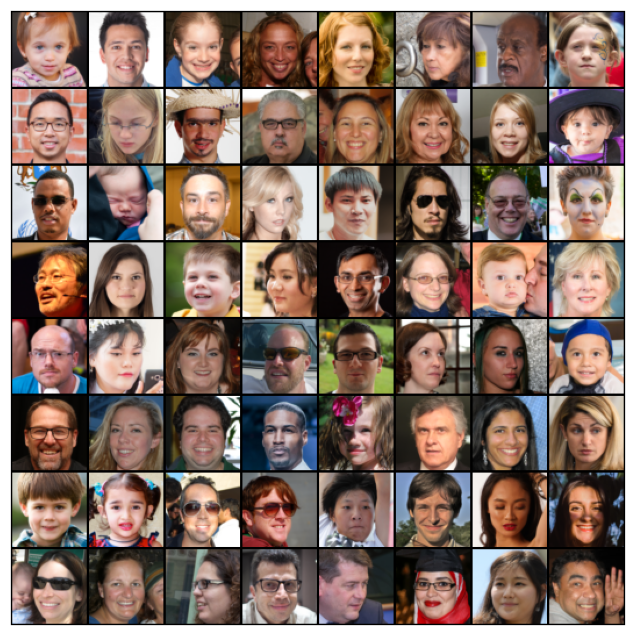

In [9]:
show_batch(train_dl)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [11]:


# инициализация весов
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



In [12]:
discriminator = nn.Sequential(
    nn.Conv2d(3, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(image_size*8, 1, kernel_size=4, stride=2, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 256 # choose latent size

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, image_size*16, kernel_size=4, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(image_size*16),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.ConvTranspose2d(image_size*16, image_size*8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(image_size),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(image_size, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
).to(device)

In [16]:
generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [17]:
lr = 0.0005

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [18]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [25]:
from IPython import display
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].to(device)
    model["generator"].to(device)
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):


        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Обучение дискриминатора
            real_images = real_images.to(device)
            optimizer["discriminator"].zero_grad()

            # Передаем реальные изображения дискриминатору
            real_preds = model["discriminator"](real_images)
            real_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Генерируем изображений
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Передаем сгенерированные изображения дискриминатору
            fake_targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.0, 0.05).to(device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Обучаем генератор
            optimizer["generator"].zero_grad()
            
            # Генерируем изображения
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Передаем сгенерированные изображения дискриминатору
            preds = model["discriminator"](fake_images)
            targets = torch.FloatTensor(real_images.size(0), 1).uniform_(0.95, 1.0).to(device)
            loss_g = criterion["generator"](preds, targets)
            
            # Обновляем веса
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Запись в историю
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Логирование
        display.clear_output(wait=True)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Пример генерации
        plt.figure(figsize=(12,12))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images.to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
        plt.show()
        if epoch:
              save_samples(epoch+start_idx, fixed_latent, show=False)
            
        plt.subplot(2, 1, 1)
        plt.plot(np.arange(len(losses_g)), losses_g, label='losses_g')
        plt.plot(np.arange(len(losses_d)), losses_d, label='losses_d')
        plt.xlabel('Epoch')
        plt.title('loss')
        plt.legend()
        plt.show()    
        
        plt.subplot(2, 1, 2)
        plt.plot(np.arange(len(real_scores)), real_scores, label='real_scores')
        plt.plot(np.arange(len(fake_scores)), fake_scores, label='fake_scores')
        plt.xlabel('Epoch')
        plt.title('score')
        plt.legend()
        plt.show()  
        
    return losses_g, losses_d, real_scores, fake_scores

In [26]:
epochs = 25

Epoch [25/25], loss_g: 4.3535, loss_d: 0.8179, real_score: 0.7702, fake_score: 0.2329


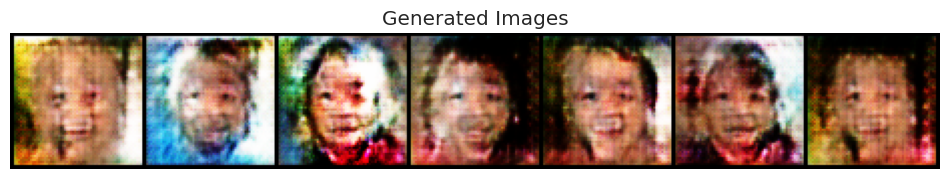

Saving generated-images-0025.png


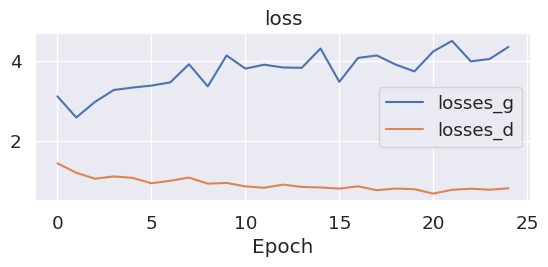

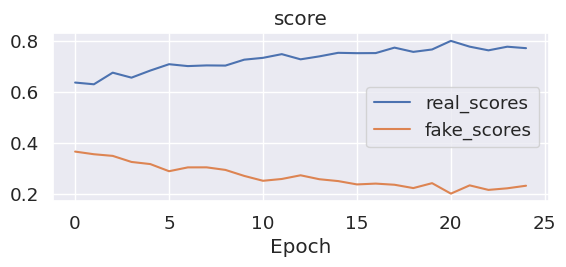

In [27]:
history = fit(model, criterion, epochs, lr)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [29]:
n_images = 12

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

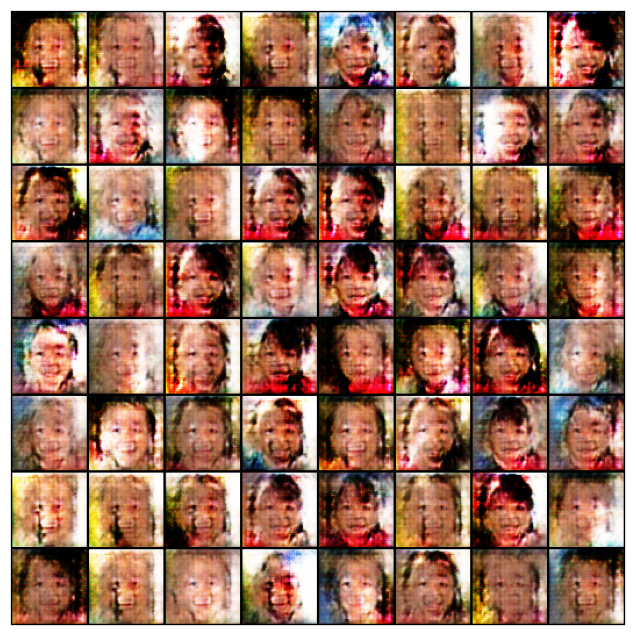

In [32]:
def showImage(image, quantityImage):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(image.detach()[:quantityImage]), nrow=8).permute(1, 2, 0))
  fig.show()



def showGenerateImage(generator, latentSpace):
  generateImages = generator(latentSpace)
  showImage(generateImages.cpu(), latentSpace.shape[0])
     

n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
showGenerateImage(model["generator"], fixed_latent)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

n_images = 1000

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"].to(device)(fixed_latent)
real_images = next(iter(get_dataloader(64, n_images)))[0]
  

zeros = torch.zeros(n_images, 1, device='cpu')
ones = torch.ones(n_images, 1, device='cpu')

X = torch.cat((fake_images.cpu(), real_images.cpu())).detach().numpy().reshape(-1, 3*64*64)
y = torch.cat((zeros, ones)).detach().numpy()


In [47]:



loo = LeaveOneOut()

accuracy = []
for train_index, test_index in loo.split(X):
  knn = KNeighborsClassifier(1)
  xTrain = X[train_index]
  yTrain = y[train_index]
  knn.fit(xTrain, yTrain)
  accuracy.append(accuracy_score(y[test_index], knn.predict(X[test_index])))
     


np.mean(accuracy)
     


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

0.9705

In [48]:
np.mean(accuracy)

0.9705

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

<ipython-input-51-f4d361e7bf48>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(downLatent[:,0], downLatent[:,1], c = y, cmap=plt.cm.get_cmap("jet", 2))


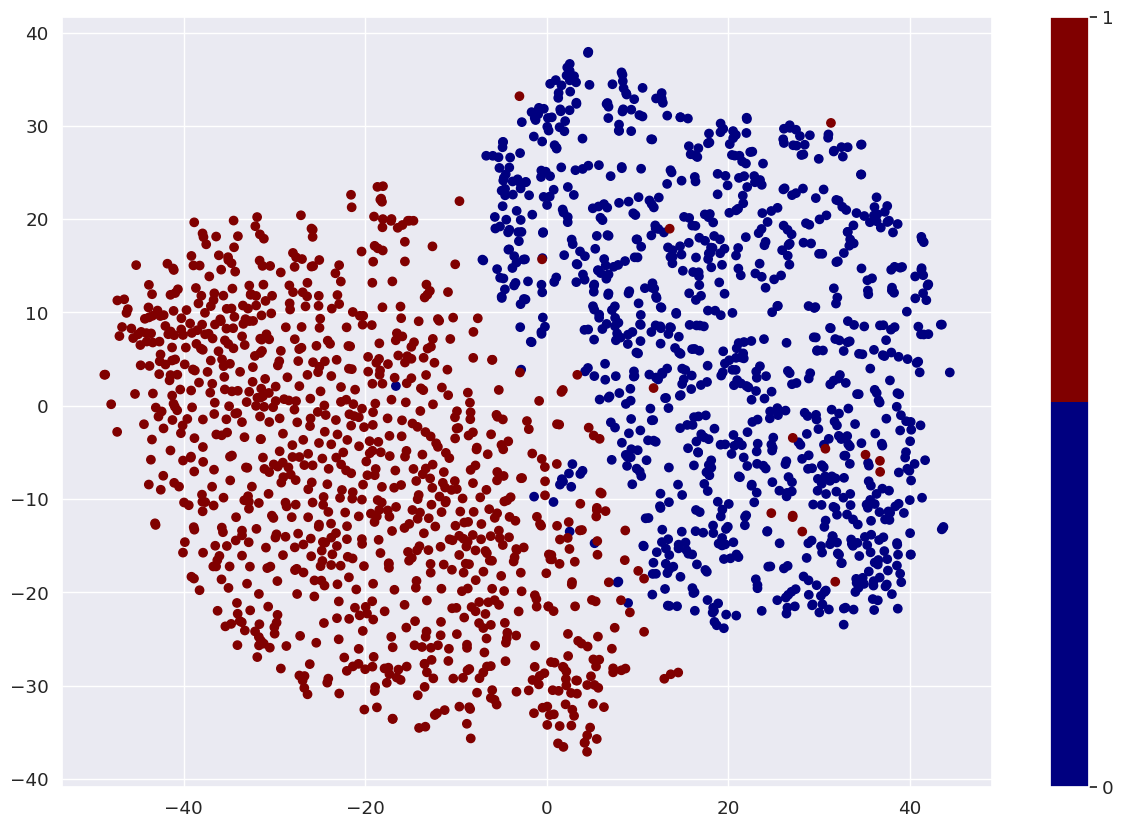

In [51]:
from sklearn.manifold import TSNE

latent = []
label = []
downSpace = TSNE()
downLatent = downSpace.fit_transform(X)

plt.figure(figsize=(15, 10))
plt.scatter(downLatent[:,0], downLatent[:,1], c = y, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.show();
     


Прокомментируйте получившийся результат: